In [2]:
import cv2
import glob
import os
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
def extract_hand(image):
# Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Remove the shadow using the RGB color space
    b, g, r = cv2.split(image)
    bg_diff = cv2.absdiff(b, g)
    br_diff = cv2.absdiff(b, r)
    shadow_mask = cv2.bitwise_and(bg_diff, br_diff)
    _, shadow_mask = cv2.threshold(shadow_mask, 35, 255, cv2.THRESH_BINARY)
    shadow_mask = cv2.morphologyEx(shadow_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
    shadow_mask = cv2.merge([shadow_mask, shadow_mask, shadow_mask])
    img_no_shadow = cv2.subtract(image, shadow_mask)

    # Convert the image to grayscale
    gray_no_shadow = cv2.cvtColor(img_no_shadow, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to convert the image to a binary image
    thresh = cv2.adaptiveThreshold(gray_no_shadow, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Remove noise from the binary image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Remove small contours and fill holes in the hand region
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hand_mask = np.zeros_like(closed)
    for cnt in contours:
        if cv2.contourArea(cnt) > 10000:
            cv2.drawContours(hand_mask, [cnt], 0, (255, 255, 255), -1)

    # Remove any remaining artifacts from the shadow
    shadow_mask = cv2.bitwise_not(hand_mask)
    shadow_mask = cv2.morphologyEx(shadow_mask, cv2.MORPH_OPEN, kernel)
    shadow_mask = cv2.morphologyEx(shadow_mask, cv2.MORPH_CLOSE, kernel)
    shadow_mask = cv2.bitwise_not(shadow_mask)

    # Apply the mask to remove the shadow
    hand = cv2.bitwise_and(closed, shadow_mask)

    # Invert the image to get the hand region as white and the background as black
    hand = cv2.bitwise_not(hand)

    # Return the hand image
    return hand

In [17]:
def divide_image(image):
    # Get image dimensions
    height, width = image.shape[:2]
    print(height,width)

    # Divide image into four quarters
    top_left = image[0:height//2, 0:width//2]
    top_right = image[0:height//2, width//2:width]
    bottom_left = image[height//2:height, 0:width//2]
    bottom_right = image[height//2:height, width//2:width]

    # Show the divided images
    plt.figure()
    plt.imshow(top_left)
    plt.figure()
    plt.imshow(top_right)
    plt.figure()
    plt.imshow(bottom_left)
    plt.figure()
    plt.imshow(bottom_right)
    
    return top_left, top_right, bottom_left, bottom_right

2592 4608


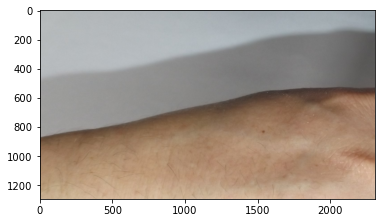

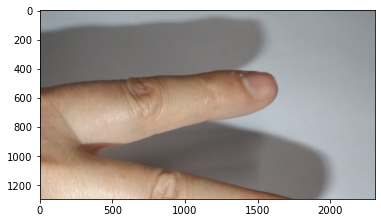

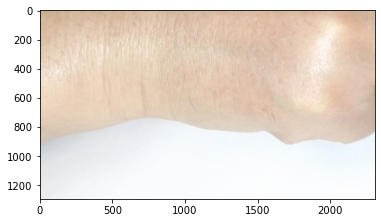

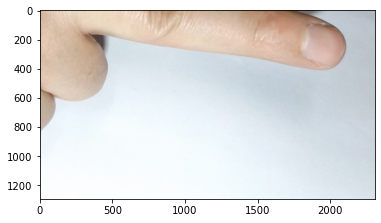

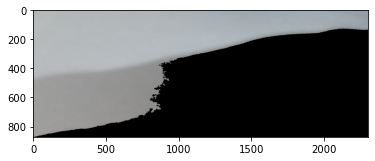

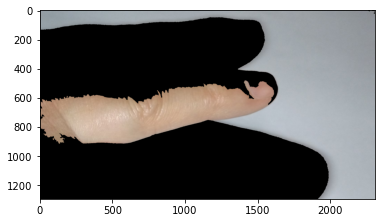

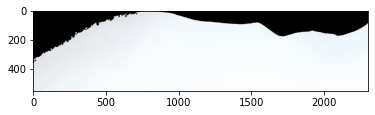

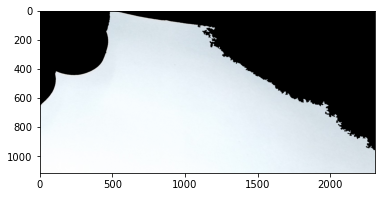

In [20]:
# #Contrast enhancement function
# # converting to LAB color space
# def contrast_enhancement (img):
#     lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
#     l_channel, a, b = cv2.split(lab)

#     # Applying CLAHE to L-channel
#     # feel free to try different values for the limit and grid size:
#     clahe = cv2.createCLAHE(clipLimit=20.0, tileGridSize=(8,8))
#     cl = clahe.apply(l_channel)

#     # merge the CLAHE enhanced L-channel with the a and b channel
#     limg = cv2.merge((cl,a,b))

#     # Converting image from LAB Color model to BGR color spcae
#     enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

#     return enhanced_img

# Contrast enhancement function
def contrast_enhancement(img):
    # Check if the image loaded correctly
    if img is None:
        print('Error: Could not load image')
        return None

    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return enhanced_img

image = cv2.cvtColor(cv2.imread('Dataset_0-5-001/men/2/2_men (103).JPG'),cv2.COLOR_BGR2RGB)
# plt.imshow(image)
top_left, top_right, bottom_left, bottom_right = divide_image(image)
# enhanced_image = contrast_enhancement(image)
# plt.imshow(enhanced_image)


# plt.imshow(segmented)

In [4]:
# # Load the dataset of images
# # Each image is a grayscale image of size 64x128

# dataset_path_men = 'Dataset_0-5-001/men/'
# image_paths_men = []

# for root, dirs, files in os.walk(dataset_path_men):
#     for file in files:
#         if file.endswith('.JPG'):
#             image_paths_men.append(os.path.join(root, file))

# dataset_path_women = 'Dataset_0-5-001/women/'
# image_paths_women = []

# for root, dirs, files in os.walk(dataset_path_women):
#     for file in files:
#         if file.endswith('.JPG'):
#             image_paths_women.append(os.path.join(root, file))

# image_paths = image_paths_men + image_paths_women

# num_images = len(image_paths)
# num_samples = int(num_images * 0.02)  # Choose 20% of the images
# sample_indices = random.sample(range(num_images), num_samples)
# sample_images = [image_paths[i] for i in sample_indices]

# print (len(sample_images))

# # dataset_path = '0/'
# # image_paths = glob.glob(os.path.join(dataset_path, '*.JPG'))

# # Define the HOG parameters
# orientations = 9
# pixels_per_cell = (8, 8)
# cells_per_block = (3, 3)
# block_norm = 'L2-Hys'

# # Extract the HOG features from each image
# hog_features = []
# labels = []
# for image_path in sample_images:
#     # grey_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     bgr_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     enhanced_image = contrast_enhancement(bgr_image)
#     cv2.imshow('Image', enhanced_image)
#     hog_feature = hog(enhanced_image, orientations=orientations,
#                       pixels_per_cell=pixels_per_cell,
#                       cells_per_block=cells_per_block,
#                       block_norm=block_norm)
#     hog_features.append(hog_feature)
#     label = os.path.basename(image_path).split('.')[0][0]
#     labels.append(int(label))

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

# # Train the SVM classifier
# svm = LinearSVC()
# svm.fit(X_train, y_train)

# # Evaluate the classifier on the testing set
# y_pred = svm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print('y_test',y_test)
# print('y_pred',y_pred)
# print('Accuracy:', accuracy)

# Load the dataset of images
dataset_path_men = 'Dataset_0-5-001/men/'
image_paths_men = []

for root, dirs, files in os.walk(dataset_path_men):
    for file in files:
        if file.endswith('.JPG'):
            image_paths_men.append(os.path.join(root, file))

dataset_path_women = 'Dataset_0-5-001/women/'
image_paths_women = []

for root, dirs, files in os.walk(dataset_path_women):
    for file in files:
        if file.endswith('.JPG'):
            image_paths_women.append(os.path.join(root, file))

image_paths = image_paths_men + image_paths_women

num_images = len(image_paths)
num_samples = int(num_images * 0.02)  # Choose 2% of the images
sample_indices = random.sample(range(num_images), num_samples)
sample_images = [image_paths[i] for i in sample_indices]

# print(len(image_paths))

# Define the HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (3, 3)
block_norm = 'L2-Hys'

# Extract the HOG features from each image
hog_features = []
labels = []
for image_path in sample_images:
    # Load the image using cv2.imread()
    bgr_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Apply contrast enhancement to the image
    enhanced_image = extract_hand(bgr_image)

    # Extract the HOG features from the enhanced image
    if enhanced_image is not None:
        hog_feature = hog(enhanced_image, orientations=orientations,
                          pixels_per_cell=pixels_per_cell,
                          cells_per_block=cells_per_block,
                          block_norm=block_norm)
        hog_features.append(hog_feature)
        label = os.path.basename(image_path).split('.')[0][0]
        labels.append(int(label))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

# Train the SVM classifier
svm = LinearSVC()
svm.fit(X_train, y_train)

# Evaluate the classifier on the testing set
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# print('y_test', y_test)
# print('y_pred', y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.125
